Based on the code from this [Github issue](https://github.com/Microsoft/LightGBM/issues/1182).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor

np.random.seed(1)

## Prepare Dataset

In [2]:
def f(x):
    """The function to predict."""
    return x * np.sin(x)

#----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
X = X.astype(np.float32)

# Observations
y = f(X).ravel()

dy = 1.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise
y = y.astype(np.float32)

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
xx = np.atleast_2d(np.linspace(0, 10, 1000)).T
xx = xx.astype(np.float32)

X.shape, y.shape, xx.shape

((100, 1), (100,), (1000, 1))

## Shared Hyper-Parameters

In [3]:
# model parameters
LEARNING_RATE = 0.1
N_ESTIMATORS = 500
MAX_DEPTH = 6
NUM_LEAVES = 128 # lgbm only
OBJECTIVE = 'quantile' # lgbm only, 'quantile' or 'quantile_l2'
REG_SQRT = True # lgbm only

ALPHA = 0.95

## Plot Function

In [4]:
def plot(y_pred, y_upper, y_lower, frac_above_upper, frac_below_lower):
    plt.figure(figsize=(10, 7), dpi=100)
    plt.plot(xx, f(xx), 'g:', label=u'$f(x) = x\,\sin(x)$')
    plt.plot(X, y, 'b.', markersize=5, label=u'Observations')
    plt.plot(xx, y_pred, 'r-', label=u'Mean Prediction')
    plt.plot(xx, y_upper, 'k-')
    plt.plot(xx, y_lower, 'k-')
    plt.fill(np.concatenate([xx, xx[::-1]]),
                np.concatenate([y_upper, y_lower[::-1]]),
                alpha=0.5, fc='b', ec='None', label=(str(round(100*(ALPHA-0.5)*2))+'% prediction interval'))
    plt.scatter(x=X[y_autohigh < y], y=y[y_autohigh < y], s=50, marker='x', c = 'red', 
            label = str(round(100*frac_above_upper,1))+'% of training data above upper (expect '+str(round(100*(1-ALPHA),1))+'%)')
    plt.scatter(x=X[y_autolow > y], y=y[y_autolow > y], s=50, marker='x', c = 'orange', 
            label = str(round(100*frac_below_lower,1))+ '% of training data below lower (expect '+str(round(100*(1-ALPHA),1))+'%)')
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')
    plt.ylim(-10, 20)
    plt.legend(loc='upper left')
    plt.title(  '  Alpha: '+str(ALPHA) +
                '  N_est: '+str(N_ESTIMATORS) +
                '  L_rate: '+str(LEARNING_RATE) +
                '  N_Leaf: '+str(NUM_LEAVES) + 
                '  Obj: '+str(OBJECTIVE) +
                '  R_sqrt: '+str(int(REG_SQRT))
            )
    plt.show()

## Scikit-learn Model

In [5]:
if MAX_DEPTH < 0:  # sklearn grows differently than lgbm.
    print('Max Depth specified is incompatible with sklearn. Changing to 3.')
    SK_MAX_DEPTH = 5
else:
    SK_MAX_DEPTH = MAX_DEPTH - 1

### Upper Bound

In [6]:
clfh = GradientBoostingRegressor(loss='quantile', alpha=ALPHA,
                n_estimators=N_ESTIMATORS, max_depth=SK_MAX_DEPTH,
                learning_rate=LEARNING_RATE, min_samples_leaf=9,
                min_samples_split=9)

clfh.fit(X, y)

GradientBoostingRegressor(alpha=0.95, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='quantile', max_depth=5,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=9, min_samples_split=9,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

### Lower Bound

In [7]:
clfl = GradientBoostingRegressor(loss='quantile', alpha=1.0-ALPHA,
        n_estimators=N_ESTIMATORS, max_depth=SK_MAX_DEPTH,
        learning_rate=LEARNING_RATE, min_samples_leaf=9,
        min_samples_split=9)
clfl.fit(X, y)

GradientBoostingRegressor(alpha=0.050000000000000044,
             criterion='friedman_mse', init=None, learning_rate=0.1,
             loss='quantile', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=9,
             min_samples_split=9, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

### Median

In [8]:
clf = GradientBoostingRegressor(loss='lad',
        n_estimators=N_ESTIMATORS, max_depth=SK_MAX_DEPTH,
        learning_rate=LEARNING_RATE, min_samples_leaf=9,
        min_samples_split=9)
clf.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=9,
             min_samples_split=9, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

### Prediction

In [9]:
# Make the prediction on the meshed x-axis
y_pred = clf.predict(xx)
y_lower = clfl.predict(xx)
y_upper = clfh.predict(xx)

# Check calibration by predicting the training data.
y_autopred = clf.predict(X)
y_autolow = clfl.predict(X)
y_autohigh = clfh.predict(X)
frac_below_upper = round(np.count_nonzero(y_autohigh > y) / len(y),3)
frac_above_upper = round(np.count_nonzero(y_autohigh < y) / len(y),3)
frac_above_lower = round(np.count_nonzero(y_autolow < y) / len(y),3)
frac_below_lower = round(np.count_nonzero(y_autolow > y) / len(y),3)

### Plot

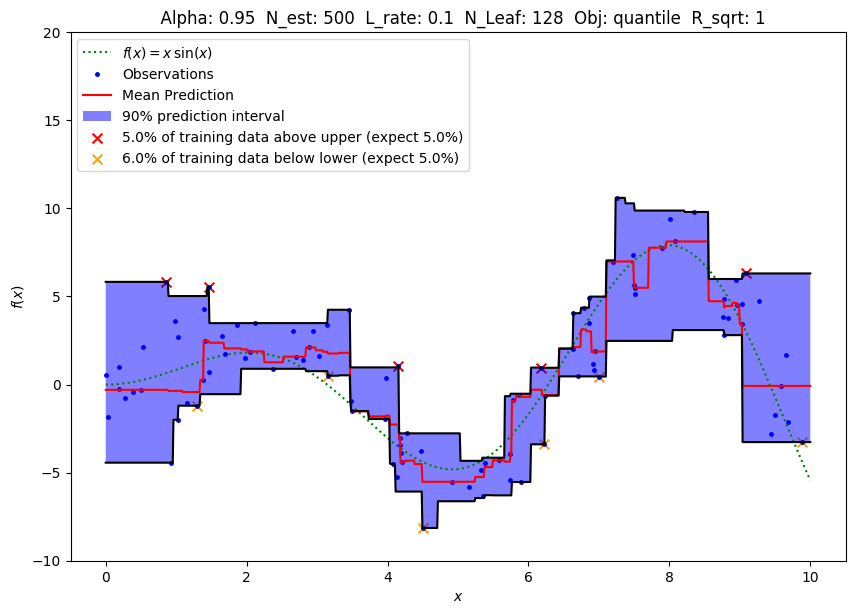

In [10]:
plot(y_pred, y_upper, y_lower, frac_above_upper, frac_below_lower)

## LightGBM Model

### Upper Bound

In [11]:
clfh = lgb.LGBMRegressor(objective = OBJECTIVE,
                        alpha = ALPHA,
                        num_leaves = NUM_LEAVES,
                        learning_rate = LEARNING_RATE,
                        n_estimators = N_ESTIMATORS,
                        min_data_in_leaf=5,
                        reg_sqrt = REG_SQRT,
                        max_depth = MAX_DEPTH)
clfh.fit(X, y)

LGBMRegressor(alpha=0.95, boosting_type='gbdt', class_weight=None,
       colsample_bytree=1.0, learning_rate=0.1, max_depth=6,
       min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=5,
       min_split_gain=0.0, n_estimators=500, n_jobs=-1, num_leaves=128,
       objective='quantile', random_state=None, reg_alpha=0.0,
       reg_lambda=0.0, reg_sqrt=True, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

### Lower Bound

In [12]:
clfl = lgb.LGBMRegressor(objective = OBJECTIVE,
                        alpha = 1 - ALPHA,
                        num_leaves = NUM_LEAVES,
                        learning_rate = LEARNING_RATE,
                        n_estimators = N_ESTIMATORS,
                        min_data_in_leaf=5,
                        reg_sqrt = REG_SQRT,
                        max_depth = MAX_DEPTH)
clfl.fit(X, y)

LGBMRegressor(alpha=0.050000000000000044, boosting_type='gbdt',
       class_weight=None, colsample_bytree=1.0, learning_rate=0.1,
       max_depth=6, min_child_samples=20, min_child_weight=0.001,
       min_data_in_leaf=5, min_split_gain=0.0, n_estimators=500, n_jobs=-1,
       num_leaves=128, objective='quantile', random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, reg_sqrt=True, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

### Median

In [13]:
clf = lgb.LGBMRegressor(objective = "regression_l1",
                        num_leaves = NUM_LEAVES,
                        learning_rate = LEARNING_RATE,
                        n_estimators = N_ESTIMATORS,
                        min_data_in_leaf=5,
                        reg_sqrt = REG_SQRT,
                        max_depth = MAX_DEPTH)
clf.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=6, min_child_samples=20,
       min_child_weight=0.001, min_data_in_leaf=5, min_split_gain=0.0,
       n_estimators=500, n_jobs=-1, num_leaves=128,
       objective='regression_l1', random_state=None, reg_alpha=0.0,
       reg_lambda=0.0, reg_sqrt=True, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

### Prediction

In [14]:
# Make the prediction on the meshed x-axis
y_pred = clf.predict(xx)
y_lower = clfl.predict(xx)
y_upper = clfh.predict(xx)

# Check calibration by predicting the training data.
y_autopred = clf.predict(X)
y_autolow = clfl.predict(X)
y_autohigh = clfh.predict(X)
frac_below_upper = round(np.count_nonzero(y_autohigh > y) / len(y),3)
frac_above_upper = round(np.count_nonzero(y_autohigh < y) / len(y),3)
frac_above_lower = round(np.count_nonzero(y_autolow < y) / len(y),3)
frac_below_lower = round(np.count_nonzero(y_autolow > y) / len(y),3)

### Plot

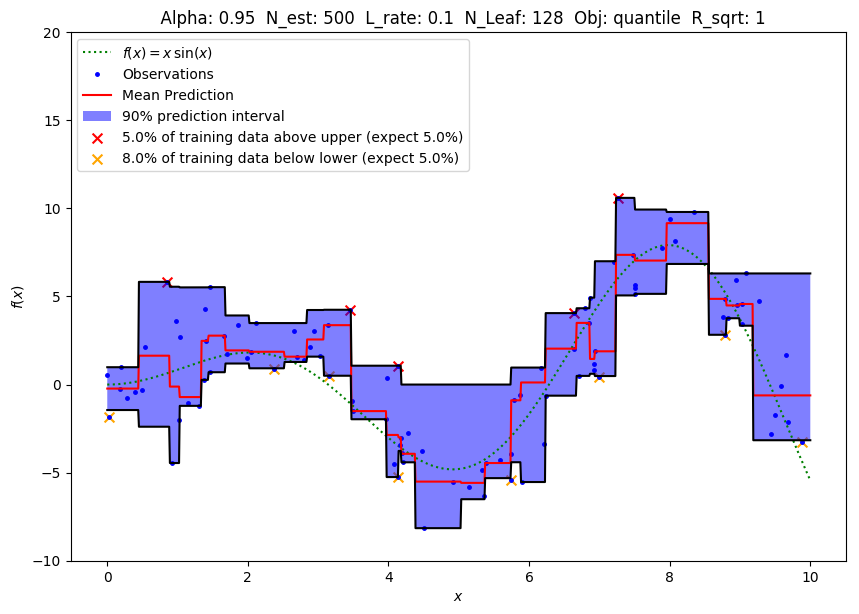

In [15]:
plot(y_pred, y_upper, y_lower, frac_above_upper, frac_below_lower)